# 线性回归

## 生成数据集

In [2]:
import torch

In [3]:
# 定义一个生成数据的函数
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 添加一些噪声
    return X, y.reshape((-1, 1))


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[:5])
print('labels:', labels[:5])

features: tensor([[ 0.2006,  1.1955],
        [-0.8768, -1.6206],
        [ 1.3953, -0.9368],
        [ 0.2744,  0.4404],
        [ 0.4804,  1.3316]])
labels: tensor([[ 0.5458],
        [ 7.9457],
        [10.1690],
        [ 3.2646],
        [ 0.6534]])


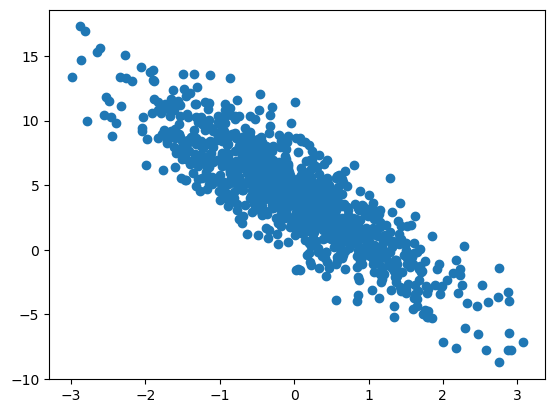

In [5]:
import matplotlib.pyplot as plt
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy())
plt.show()

## 读取数据集

In [6]:
from torch.utils import data


def load_array(data_arrays, batch_size, is_train=True):
    """构造一个数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)  # "*"表示解压可迭代对象
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


batch_size = 10  # 每个小批量样本的样本数
data_iter = load_array((features, labels), batch_size)

In [7]:
# 从迭代器中获取第一项
next(iter(data_iter))

[tensor([[ 0.7643, -1.1003],
         [-0.4115, -0.6478],
         [-0.3819,  0.6987],
         [-0.0524,  0.0363],
         [ 0.8257, -1.2701],
         [ 2.3928, -1.6585],
         [ 0.6379, -0.3892],
         [ 0.2223,  1.4223],
         [ 1.1385, -0.8345],
         [-0.0350,  1.5625]]),
 tensor([[ 9.4611],
         [ 5.5878],
         [ 1.0719],
         [ 3.9747],
         [10.1582],
         [14.6115],
         [ 6.7916],
         [-0.1775],
         [ 9.3241],
         [-1.1862]])]

## 定义模型

In [9]:
# nn是神经网络的缩写
from torch import nn

# PyTorch的全连接层在Linear类中定义
net = nn.Sequential(nn.Linear(2, 1))  # 第1个参数指定输入特征形状，第2个参数指定输出特征形状。

## 初始化模型参数

In [10]:
# 通过net[0]选择网络中第一个图层
net[0].weight.data.normal_(0, 0.01)  # 用weight.data访问权重参数
net[0].bias.data.fill_(0)  # 用bias.data访问偏置参数

tensor([0.])

## 定义损失函数

In [11]:
# 使用均方误差MSE作为损失函数
loss = nn.MSELoss()

## 定义优化算法

In [12]:
# 实例化小批量随机梯度下降算法
# net.parameters()获取参数，lr设置学习率
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练

In [22]:
num_epochs = 3  # 迭代次数

for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)  # 计算当前批次损失
        trainer.zero_grad()  # 梯度清零
        l.backward()  # 反向传播
        trainer.step()  # 优化参数
    l = loss(net(features), labels)  # 计算整个训练集上的损失
    print(f'epoch {epoch+1}, loss:{l:f}')

epoch 1, loss:0.000096
epoch 2, loss:0.000096
epoch 3, loss:0.000096


In [24]:
# 比较模型参数与真实参数
w = net[0].weight.data
print(w)
print(f'w的估计误差：{w - true_w}')
b = net[0].bias.data
print(b)
print(f'b的估计误差: {b - true_b}')

tensor([[ 2.0010, -3.4004]])
w的估计误差：tensor([[ 0.0010, -0.0004]])
tensor([4.2003])
b的估计误差: tensor([0.0003])


# 图像分类数据集

In [16]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

## 读取数据集

In [20]:
# 通过ToTensor实例将图像数据从PIL类型变换成浮点数，并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()

# 读取FashionMNIST数据集
mnist_train = torchvision.datasets.FashionMNIST(
    root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=trans, download=True)

In [21]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [22]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [23]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [24]:
mnist_train[0][1]

9

In [25]:
# 创建函数用于将数字label转为名称
def get_fashion_mnist_labels(labels):
    """返回fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [30]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=2):
    """绘制图像"""
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # 展平子图数组为一维数组，便于后续循环中遍历每个子图

    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)

    # 设置x，y轴坐标不可见
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    # 设置子图标签
        if titles:
            ax.set_title(titles[i])
    return axes

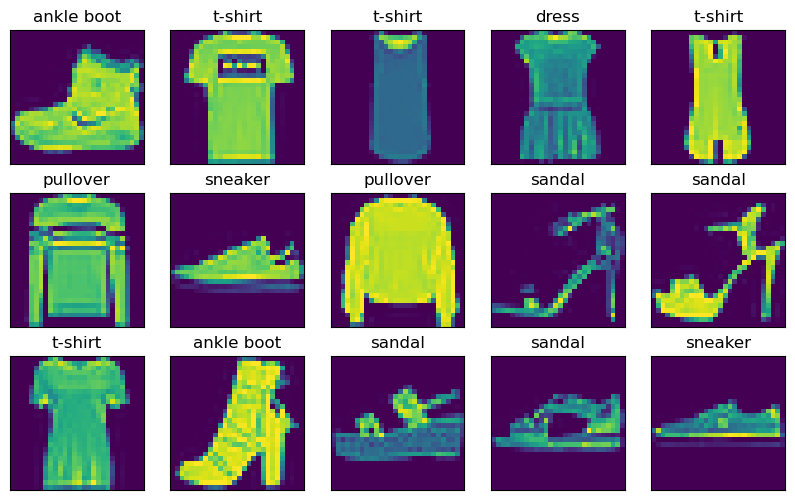

In [31]:
# 获取前15个样本的图片和标签
X, y = next(iter(data.DataLoader(mnist_train, batch_size=15)))

# 展示图片
show_images(X.reshape(15, 28, 28), 3, 5, titles=get_fashion_mnist_labels(y))
plt.show()

In [32]:
X.shape

torch.Size([15, 1, 28, 28])

## 读取小批量

In [33]:
batch_size = 256


def get_dataloader_workers():
    """使用4个进程读取数据"""
    return 4


train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

## 整合组件

In [34]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""

    # 创建存储图像转换操作的列表，包含ToTensor实例
    trans = [transforms.ToTensor()]

    if resize:
        trans.insert(0, transforms.Resize(resize))  # 将Resize实例加入转换列表
    trans = transforms.Compose(trans)  # 将多个图像转换的操作合并

    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)

    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [35]:
# 每个小批量取32个样本，并将图像转换为64*64
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)  # 转化为64*64图像

for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# Softmax回归

In [17]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

## 加载数据

In [36]:
batch_size = 256

train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 模型

In [37]:
from torch import nn

# 在线性层前定义Flatten层，调整网络输入的形状
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 10))


def init_weight(m):
    """对权重正态分布初始化"""
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weight)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## 损失函数

In [38]:
# 使用交叉熵损失，默认采用均值
loss = nn.CrossEntropyLoss()

## 分类精度

In [46]:
# 定义累加器Accumulator类，用于对多个变量进行累加
class Accumulator:
    """对n个变量进行累加操作"""

    def __init__(self, n):
        # 初始化累加器数据
        self.data = [0.0] * n

    def add(self, *args):
        # 将data列表中的每个元素a与args中对应位置的参数b相加，得到新的元素值，组成新的列表
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        # 重置累加器数据
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        # 获取累加器数据
        return self.data[idx]

In [41]:
# 示例
y = torch.tensor([0, 2])  # 真实类别
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  # 模型输出的每种类别的概率
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [42]:
def accuracy(y_hat, y):
    """计算正确预测的数量"""

    # 获取模型预测的分类标签（概率最大的类别）
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)

    # 判断是否预测正确
    cmp = (y_hat.type(y.dtype) == y)

    # 输出正确预测的总数
    return float(cmp.sum())

In [43]:
accuracy(y_hat, y) / len(y)

0.5

In [44]:
# 定义计算分类精度的函数
def evaluate_accuracy(net, data_iter):
    """计算模型准确度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式

    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())  # 添加正确预测数、样本总数

        # 返回预测正确率
    return metric[0] / metric[1]

## 优化算法

In [40]:
# 使用随机梯度下降，学习率为0.1
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练函数

In [58]:
def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""

    # 设置累加器，计算训练损失总和、训练集上的正确预测总和、样本数
    metric = Accumulator(3)

    # 设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        batch_loss = loss(y_hat, y)
        total_loss = batch_loss * y.numel()
        updater.zero_grad()
        batch_loss.backward()  # 反向传播
        updater.step()  # 更新参数

        metric.add(total_loss, accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练集准确度
    return metric[0] / metric[2], metric[1] / metric[2]

In [56]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, updater)
        train_loss = round(train_loss, 4)
        train_acc = round(train_acc, 4)
        test_acc = evaluate_accuracy(net, test_iter)
        test_acc = round(test_acc, 4)

        print(
            f'epoch[{epoch + 1}/{num_epochs}], loss={train_loss} train_accuracy={train_acc} test_accuracy={test_acc}')

    print('训练完成！')

## 训练轮数

In [85]:
# 设置训练轮数
num_epochs = 10

## 训练

In [67]:
# 开始训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch[1/10], loss=0.5014 train_accuracy=0.8311 test_accuracy=0.8215
epoch[2/10], loss=0.4853 train_accuracy=0.838 test_accuracy=0.8286
epoch[3/10], loss=0.4739 train_accuracy=0.8399 test_accuracy=0.826
epoch[4/10], loss=0.4654 train_accuracy=0.8418 test_accuracy=0.8194
epoch[5/10], loss=0.458 train_accuracy=0.8446 test_accuracy=0.8318
epoch[6/10], loss=0.452 train_accuracy=0.847 test_accuracy=0.8273
epoch[7/10], loss=0.4465 train_accuracy=0.8485 test_accuracy=0.8277
epoch[8/10], loss=0.4425 train_accuracy=0.8492 test_accuracy=0.8298
epoch[9/10], loss=0.439 train_accuracy=0.8503 test_accuracy=0.8351
epoch[10/10], loss=0.436 train_accuracy=0.852 test_accuracy=0.8348
训练完成！


In [229]:
# 直接在训练函数内计算精确度

def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""

    # 设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

        # 初始化
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        batch_loss = loss(y_hat, y)
        updater.zero_grad()
        batch_loss.backward()  # 反向传播
        updater.step()  # 更新参数

        total_loss += batch_loss.item() * y.numel()  # 计算训练集总损失
        total_correct += (y_hat.argmax(1) == y).sum().item()  # 计算正确预测总数
        total_samples += y.numel()  # 计算总样本数

    average_loss = total_loss / total_samples  # 计算训练集上平均损失

    # 计算训练集上的准确度
    train_acc = total_correct / total_samples

    # 返回平均损失和训练集上的准确度
    return average_loss, train_acc

In [66]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""

    for epoch in range(num_epochs):
        average_loss, train_acc = train_epoch(net, train_iter, loss, updater)
        average_loss = round(average_loss, 4)
        train_acc = round(train_acc, 4)

        # 在每个训练周期结束后计算测试集准确度
        net.eval()
        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            for X, y in test_iter:
                y_hat = net(X)
                total_correct += (y_hat.argmax(1) == y).sum().item()
                total_samples += y.numel()
            test_acc = round(total_correct / total_samples, 4)

        print(
            f'epoch[{epoch + 1}/{num_epochs}], loss={average_loss} train_accuracy={train_acc} test_accuracy={test_acc}')

    print('训练完成！')

In [226]:
# 开始训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch1: loss=0.4168 train_accuracy=0.8577 test_accuracy=0.8407
epoch2: loss=0.4136 train_accuracy=0.859 test_accuracy=0.8403
epoch3: loss=0.4132 train_accuracy=0.8581 test_accuracy=0.841
epoch4: loss=0.4122 train_accuracy=0.8586 test_accuracy=0.8401
epoch5: loss=0.4109 train_accuracy=0.8594 test_accuracy=0.8416
epoch6: loss=0.4102 train_accuracy=0.8597 test_accuracy=0.8402
epoch7: loss=0.4087 train_accuracy=0.8594 test_accuracy=0.8424
epoch8: loss=0.4075 train_accuracy=0.8607 test_accuracy=0.8428
epoch9: loss=0.4069 train_accuracy=0.8611 test_accuracy=0.8389
epoch10: loss=0.4061 train_accuracy=0.8605 test_accuracy=0.8339
epoch11: loss=0.4051 train_accuracy=0.8608 test_accuracy=0.8425
epoch12: loss=0.4045 train_accuracy=0.8615 test_accuracy=0.8399
epoch13: loss=0.4036 train_accuracy=0.8622 test_accuracy=0.8402
epoch14: loss=0.403 train_accuracy=0.8622 test_accuracy=0.841
epoch15: loss=0.4018 train_accuracy=0.8622 test_accuracy=0.84
epoch16: loss=0.4015 train_accuracy=0.8625 test_accurac

## 预测

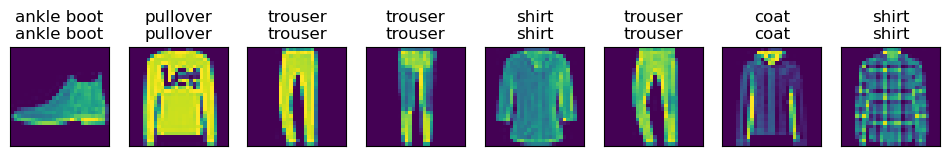

In [244]:
def predict(net, test_iter, n=8):
    """预测标签"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape(n, 28, 28), 1, n, titles=titles[0:n])


predict(net, test_iter)

## 可视化

In [64]:
# 定义一个在动画中绘制数据的实用程序类Animator
from IPython import display


class Animator:
    """在动画中绘制数据"""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数获取参数
        self.config_axes = lambda: self.axes[0].set(
            xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)
        self.X, self.Y, self.fmts = [], [], fmts  # 初始化

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
            self.Y = [[] for _ in range(n)]  # 初始化
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
# 用Animator类可视化训练进度
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1],
                    legend=['train loss', 'train acc', 'test acc'])

In [88]:
import matplotlib.pyplot as plt
import numpy as np


def train_visual(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    # 创建空列表用于存储评估指标
    epochs = []
    losses = []
    train_acc_ = []
    test_acc_ = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)

        epochs.append(epoch + 1)
        losses.append(train_loss)
        train_acc_.append(train_acc)
        test_acc_.append(test_acc)

        train_loss = round(train_loss, 4)
        train_acc = round(train_acc, 4)
        test_acc = round(test_acc, 4)

        print(
            f'epoch[{epoch + 1}/{num_epochs}], loss={train_loss} Train Accuracy={train_acc} Test Accuracy={test_acc}')

        # 可视化
    plt.figure(figsize=(8, 6))

    plt.plot(epochs, losses, 'o-', color='#39C5BB', lw=2, label='Loss')
    plt.plot(epochs, train_acc_, '.--', color='#FFE211',
             lw=2, label='Train Accuracy')
    plt.plot(epochs, test_acc_, '.--', color='#FAAFBE',
             lw=2, label='Test Accuracy')

    plt.xticks(np.arange(0, num_epochs+1, 1))
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()

    plt.show()

    print('训练完成！')

epoch[1/10], loss=0.4258 Train Accuracy=0.8545 Test Accuracy=0.8353
epoch[2/10], loss=0.424 Train Accuracy=0.8551 Test Accuracy=0.8348
epoch[3/10], loss=0.4218 Train Accuracy=0.8563 Test Accuracy=0.8341
epoch[4/10], loss=0.4199 Train Accuracy=0.8567 Test Accuracy=0.839
epoch[5/10], loss=0.4185 Train Accuracy=0.8569 Test Accuracy=0.8362
epoch[6/10], loss=0.4172 Train Accuracy=0.8574 Test Accuracy=0.8371
epoch[7/10], loss=0.4158 Train Accuracy=0.8576 Test Accuracy=0.8389
epoch[8/10], loss=0.4145 Train Accuracy=0.8576 Test Accuracy=0.8385
epoch[9/10], loss=0.4129 Train Accuracy=0.8579 Test Accuracy=0.8339
epoch[10/10], loss=0.413 Train Accuracy=0.8584 Test Accuracy=0.8394


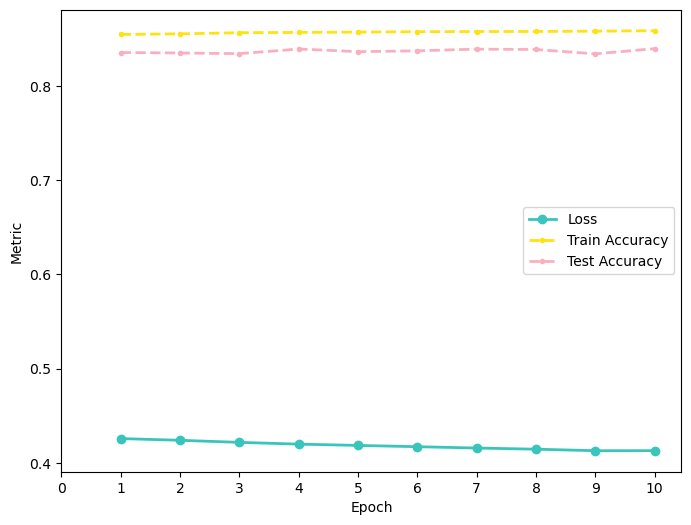

训练完成！


In [89]:
# 开始训练并可视化训练结果
train_visual(net, train_iter, test_iter, loss, num_epochs, trainer)